In [8]:
import cv2
import numpy as np

img1 = cv2.imread('left_1713973900368802035.png', 0)

sift = cv2.SIFT_create(400)
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)

img2 = cv2.imread('left_1713973900568837681.png', 0)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

print(len(keypoints1))
print(len(keypoints2))


402
400


/tmp/ipykernel_205747/2872732204.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


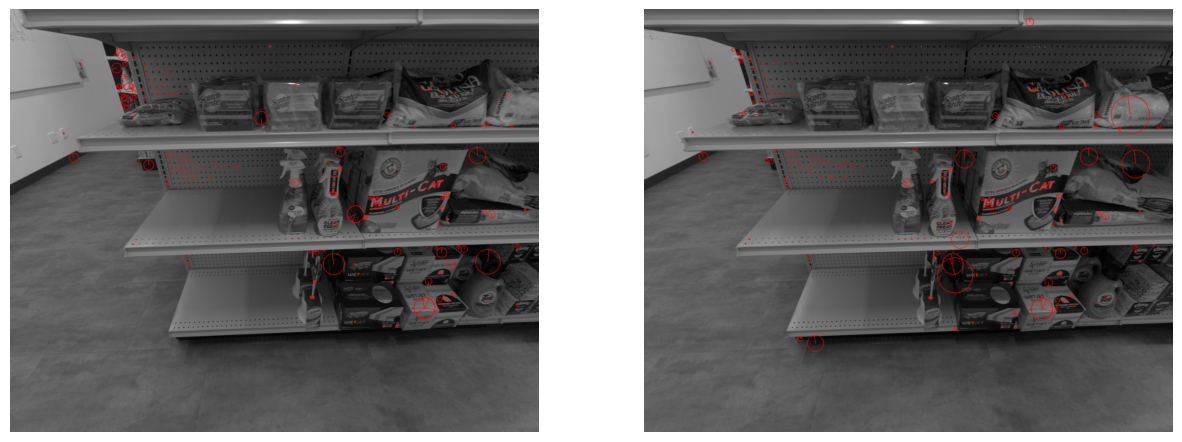

In [9]:
import matplotlib.pyplot as plt

img1kp = cv2.drawKeypoints(img1,keypoints1,None,(255,0,0),4)
img2kp = cv2.drawKeypoints(img2,keypoints2,None,(255,0,0),4)

f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(img1kp)
axarr[1].imshow(img2kp)
axarr[0].axis('off')
axarr[1].axis('off')
# axarr[0].set_title(closest_file.name)
# axarr[1].set_title(query_file.name)
f.show()

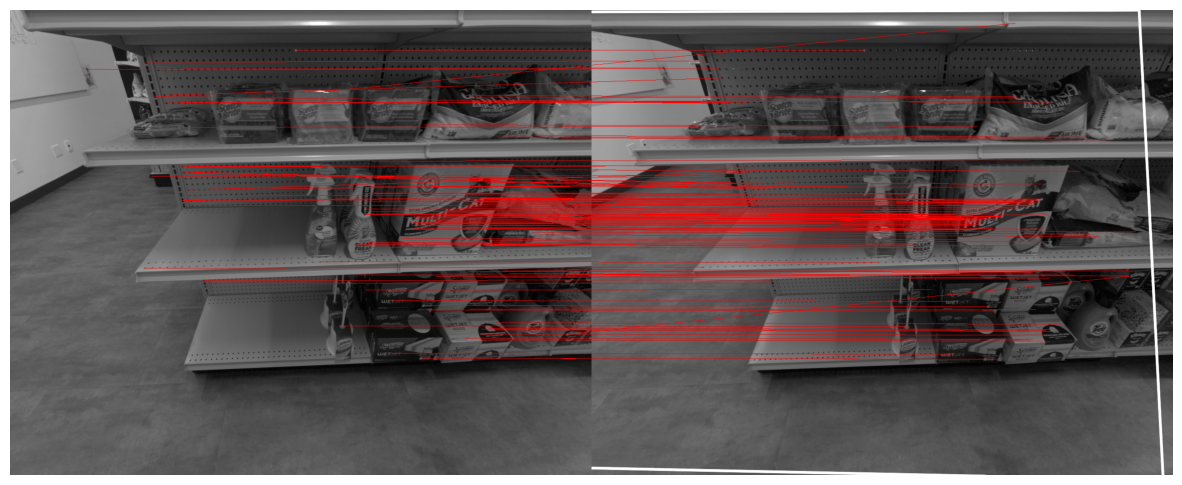

In [13]:
MIN_MATCH_COUNT = 10

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(keypoints1[m.queryIdx].pt[0]), int(keypoints1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(keypoints2[m.trainIdx].pt[0] + w1), int(keypoints2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))
    plt.figure(figsize=(15,8))
    plt.axis('off')
    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

In [15]:
print(M)

[[ 9.57549554e-01  4.00810182e-02 -5.34919748e+01]
 [-2.79622219e-03  9.70999842e-01  6.45798021e+00]
 [-2.19269862e-05 -8.84424395e-06  1.00000000e+00]]
[[[ -53.491974     6.45798  ]]

 [[ -12.603122  1008.9192   ]]

 [[1258.9127    1034.5897   ]]

 [[1205.0079       2.9647574]]]
